# CT Segmentation
## 폐, 기도, 심장

## LIBRARY

In [1]:
import os
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda")
print(device)
print(torch.__version__)
print(torch.cuda.is_available())

cuda
1.12.1+cu113
True


# DATA OVERVIEW

In [3]:
data_dir = "../data/segmentation/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [4]:
def extract_client_id(x):
    return x.split("_")[0]

In [5]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [6]:
print(len(data_df))

16708


In [7]:
client_ids = np.unique(data_df.Id.values)
print('Length : ', len(client_ids), '\n\nData : ', client_ids)

Length :  112 

Data :  ['ID00007637202177411956430' 'ID00009637202177434476278'
 'ID00010637202177584971671' 'ID00012637202177665765362'
 'ID00014637202177757139317' 'ID00015637202177877247924'
 'ID00019637202178323708467' 'ID00025637202179541264076'
 'ID00027637202179689871102' 'ID00032637202181710233084'
 'ID00035637202182204917484' 'ID00047637202184938901501'
 'ID00048637202185016727717' 'ID00051637202185848464638'
 'ID00060637202187965290703' 'ID00061637202188184085559'
 'ID00068637202190879923934' 'ID00072637202198161894406'
 'ID00073637202198167792918' 'ID00075637202198610425520'
 'ID00076637202199015035026' 'ID00077637202199102000916'
 'ID00082637202201836229724' 'ID00089637202204675567570'
 'ID00090637202204766623410' 'ID00094637202205333947361'
 'ID00102637202206574119190' 'ID00104637202208063407045'
 'ID00105637202208831864134' 'ID00109637202210454292264'
 'ID00110637202210673668310' 'ID00111637202210956877205'
 'ID00117637202212360228007' 'ID00119637202215426335765'
 'ID001

In [8]:
# filter bu unique ID
index = 0
client_data = data_df[data_df.Id == client_ids[index]][["ImageId", "MaskId"]]
print(client_data)

                             ImageId                                 MaskId
0    ID00007637202177411956430_0.jpg   ID00007637202177411956430_mask_0.jpg
1    ID00007637202177411956430_1.jpg   ID00007637202177411956430_mask_1.jpg
2    ID00007637202177411956430_2.jpg   ID00007637202177411956430_mask_2.jpg
3    ID00007637202177411956430_3.jpg   ID00007637202177411956430_mask_3.jpg
4    ID00007637202177411956430_4.jpg   ID00007637202177411956430_mask_4.jpg
5    ID00007637202177411956430_5.jpg   ID00007637202177411956430_mask_5.jpg
6    ID00007637202177411956430_6.jpg   ID00007637202177411956430_mask_6.jpg
7    ID00007637202177411956430_7.jpg   ID00007637202177411956430_mask_7.jpg
8    ID00007637202177411956430_8.jpg   ID00007637202177411956430_mask_8.jpg
9    ID00007637202177411956430_9.jpg   ID00007637202177411956430_mask_9.jpg
10  ID00007637202177411956430_10.jpg  ID00007637202177411956430_mask_10.jpg
11  ID00007637202177411956430_11.jpg  ID00007637202177411956430_mask_11.jpg
12  ID000076

# PREPROCESSING
### JPG는 손실압축 방법으로서 픽셀간의 근접한 부분이 어그러질 가능성이 높다.
### MASK 데이터는 .PNG, ARRAY가 제일 좋다.
### .JPG 일 경우 0 or 255로 바꾸는게 좋다. MASK의 채널은 3개다 (폐, 심장, 기도).

ID00007637202177411956430_16.jpg ID00007637202177411956430_mask_16.jpg

 MASK SHAPE :  (512, 512, 3)

 MASK UNIQUE :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 2

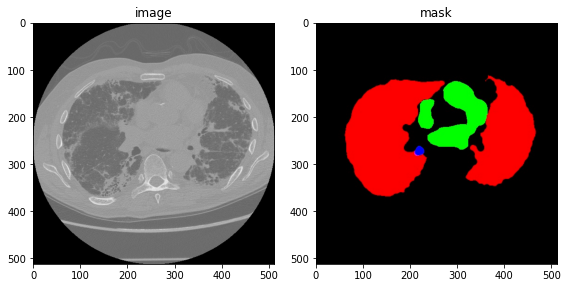

In [9]:
# Filter unique ID -> Filter sub_ID
sub_index = 16

img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)

image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

# Print
print(img_name, mask_name)
print('\n MASK SHAPE : ', mask.shape)
print('\n MASK UNIQUE : ', np.unique(mask))
# Plot
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)

plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [10]:
mask[100:150, 150]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   1,   0],
       [  0,   2,   0],
       [  0,   2,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  2,   0,   1],
       [  2,   0,   1],
       [  2,   0,   0],
       [  0,   0,   0],
       [  0,   1,   0],
       [  0,   1,   0],
       [  0,   1,   0],
       [  0,   1,   0],
       [  0,   1,   0],
       [  0,   1,   0],
       [  2,   0,   1],
       [ 12,   0,   0],
       [ 30,   0,   0],
       [ 82,   0,   0],
       [199,  10,   9],
       [242,   1,   0],
       [249,   3,   0],
       [247,   0,   0],
       [255,   5,   4],
       [252,   0,   1],
       [247,   1,   1],
       [247,   2,   0],
       [249,   1,   0],
       [251,   1,   0],
       [252,   1,   0],
       [252,   0

(512, 512)


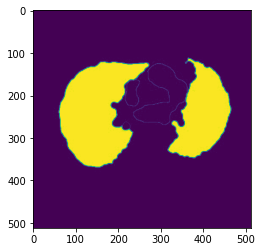

In [11]:
plt.imshow(mask[..., 0])
print(mask[..., 0].shape)

(512, 512)


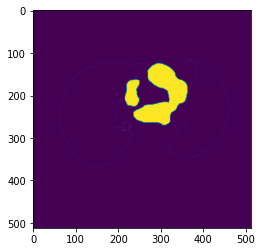

In [12]:
plt.imshow(mask[..., 1])
print(mask[..., 1].shape)

(512, 512)


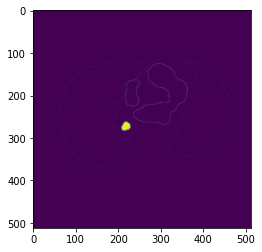

In [13]:
plt.imshow(mask[..., 2])
print(mask[..., 2].shape)

ID00007637202177411956430_16.jpg ID00007637202177411956430_mask_16.jpg

 MASK SHAPE :  (512, 512, 3)

 MASK UNIQUE :  [  0 255]


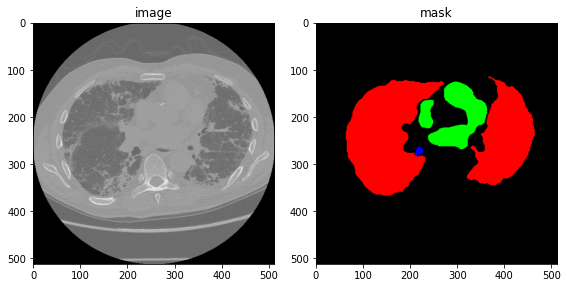

In [14]:
# Filter unique ID -> Filter sub_ID
img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

# Print
print(img_name, mask_name)
print('\n MASK SHAPE : ', mask.shape)
print('\n MASK UNIQUE : ', np.unique(mask))
# Plot
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [15]:
mask[100:150, 150]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0,   0],
       [255,   0

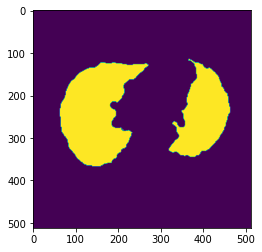

In [16]:
plt.imshow(mask[..., 0])

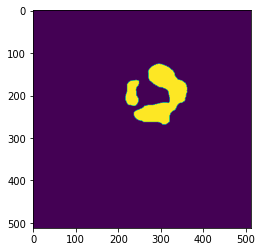

In [17]:
plt.imshow(mask[..., 1])

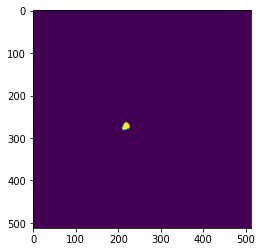

In [18]:
plt.imshow(mask[..., 2])

### SEGMENTATION NEEDS BACKGROUND
### OPEN CV : (B, G, R)

In [19]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255)) # (B, G , R)

In [20]:
def get_client_data(data_df, index):
    # 'data_df' has its unique ID
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    # Main index
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [21]:
index = 0
client_id, image_files, mask_files = get_client_data(data_df, index)

# 영상은 기본으로 8비트 'np.uint8'
# shape = (255,255) -> IMAGE + MASK 영상을 집어넣기 위해서 가로(512), 폭(512*2+50[Buffer])
grid_pad = 70
canvas = np.zeros(shape=(512, 2*512+grid_pad, 3), dtype=np.uint8)
for i in range(len(image_files)):
    # image files
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # mask files
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # MASK IMAGE PREPROCESSING
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255


    # CANVAS SETTING (512+grid_pad:2*512+grid_pad)
    canvas[:, :512, :] = image #왼쪽부터 'image'
    canvas[:, 512+grid_pad:2*512+grid_pad, :] = mask # Buffer 이후부터 'mask'
    
    text_buff = 410
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
    
    cv2.imshow('CT frames', canvas)
    key = cv2.waitKey(100)
    if key == 27:
        break
cv2.destroyAllWindows()

In [22]:
# mask -> end of the loop
# mask index needs to be set
mask
np.unique(mask)

array([0], dtype=uint8)

## TENSOR CONVERT
<pre><font size="4">
data_dir
ㄴ train
     ㄴ images = *.jpg
     ㄴ masks = *.jpg
 ㄴ mask
     ㄴ images = *.jpg
     ㄴ masks = *.jpg
</pre></font>

### cv2.resiz.interpolation :
<pre><font size="4">

https://chadrick-kwag.net/cv2-resize-interpolation-methods/

https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image
    'To shrink an image, it will generally look best with INTER_AREA interpolation,
    whereas to enlarge an image, it will generally look best with INTER_CUBIC (slow) or
    INTER_LINEAR (faster but still looks OK).'
</pre></font>

### cv2.resiz.interpolation = cv2.INTER_NEAREST :
<pre><font size="4">
* MASK -> .PNG is the best
* mask*.jpg -> replace the pixel in the nearest values. If value range (0,10),
then replace to the nearest eiter 1 or 10, not 5.
</pre></font>

In [39]:
mask_H, mask_W, mask_C = mask.shape # (512, 512, 3)
print(mask_H, mask_W, mask_C)
print_background = np.ones(shape=(mask_H, mask_W)) # 1로 가득찬 array를 생성
print('BACKGROUND SHAPE AFTER ADJUSTMENT : ', print_background.shape)
print('\nBACKGROUND : \n')
print_background

512 512 3
BACKGROUND SHAPE AFTER ADJUSTMENT :  (512, 512)

BACKGROUND : 



array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [40]:
print_background[mask[...,0] != 0] = 0 # FILL BACKGROUND [0]
print_background[mask[...,1] != 0] = 0 # FILL BACKGROUND [1]
print_background[mask[...,2] != 0] = 0 # FILL BACKGROUND [2]

print_mask = np.concatenate([np.expand_dims(print_background, -1), mask], axis=-1) # (1, 2, 3, Background)
print('\nBACKGROUND ADDED IN MASK SHAPE: \n')
print(print_mask.shape)
print('\nBACKGROUND ADDED IN MASK: \n')
print_mask


BACKGROUND ADDED IN MASK SHAPE: 

(512, 512, 4)

BACKGROUND ADDED IN MASK: 



array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0.

In [41]:
print_mask = np.argmax(print_mask, axis=-1, keepdims=False) # SQUEEZE INTO 1
print(print_mask.shape)
print(np.unique(print_mask))

print_mask

(512, 512)
[0 1 2 3]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
print_target = torch.from_numpy(mask).long()
print(print_target.shape)

torch.Size([512, 512, 3])


### DATASET CLASS

In [24]:
class CT_dataset():
    """
    data_dir = "../data/segmentation/"
    phase = "train"
    """
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]

        assert len(self.image_files) == len(self.mask_files) # https://wikidocs.net/21050

        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        # MASK -> .PNG is the best
        # mask*.jpg -> replace the pixel in the nearest values.
        # If value range (0,10), then replace to the nearest, eiter 1 or 10, not 5.
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE,IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

        # MASK IMAGE PREPROCESSING
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255 # (0,1)

        # BACKGROUND SETUP
        mask_H, mask_W, mask_C = mask.shape # (512, 512, 3)
        background = np.ones(shape=(mask_H, mask_W)) # FILL WITH 1
        background[mask[...,0] != 0] = 0 # FILL BACKGROUND [0]
        background[mask[...,1] != 0] = 0 # FILL BACKGROUND [1]
        background[mask[...,2] != 0] = 0 # FILL BACKGROUND [2]
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1) # (1, 2, 3, Background)
        mask = np.argmax(mask, axis=-1, keepdims=False) # EX) [0, 1, 2, 3] : BIGGEST CHANNEL INTO 1 DIM

        if self.transformer:
            image = self.transformer(image)

        target = torch.from_numpy(mask).long() # EX)torch.size([512, 512, 3]) : CONVERT INTO TENSOR

        return image, target

In [25]:
IMAGE_SIZE = 224

In [26]:
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # IMAGENET DATA
    ])
    return transformer

In [27]:
def collate_fn(batch):
    """
    * Formulate batch into mini batch.
    * Dataloader returns the value after "collate_fn"
    """
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

In [28]:
transformer = build_transformer()
tr_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

### DATASET CLASS RESULT

In [29]:
image_sample, target_sample = tr_dataset[0]
print(f"image shape : , {image_sample.shape}")
print(f"\ntarget_shape : , {target_sample.shape}")
print(f"target_unique : , {target_sample.unique()}")

image shape : , torch.Size([3, 224, 224])

target_shape : , torch.Size([224, 224])
target_unique : , tensor([0, 1, 3])


### DATALOADER CLASS RESULT
#### returns mini batch output

In [30]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()

    dataloaders = {}
    tr_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

## U-NET ARCHITECTURE

![](unet-architecture.png)
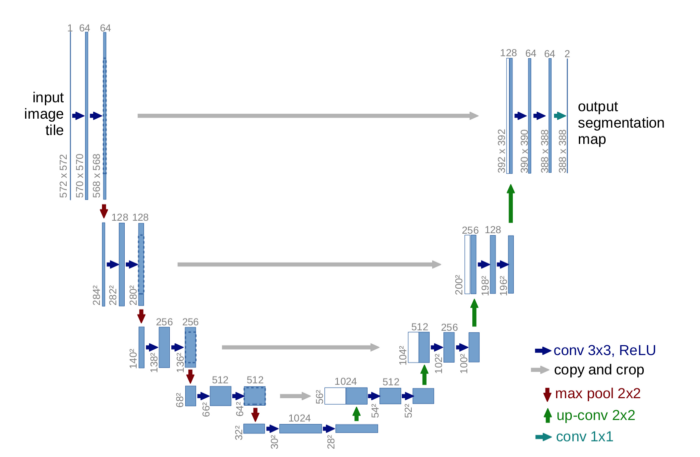

### ENCODER

In [31]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),


        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [32]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    if index == 0:
        break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])


In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out) # SKIP CONNECTION
        out = self.pool(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block5(out)
        return out, encode_features

### ENCODER TEST

In [34]:
encoder = Encoder()
x = torch.randn(1, 3, 224, 224) # (B, C, H, W)
out, ftrs = encoder(x)

for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


![](unet-architecture.png)

### DECODER

In [35]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [36]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512) # (LAST BOTTOM) UPCONV LAYER 2*2
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512) # CONCATENATE
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256) # CONCATENATE
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128) # CONCATENATE
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64) # CONCATENATE
        
    def forward(self, x, encoder_features): # encoder_features : skip-connection
        """
        encoder_features[-1] : the latest encoder (512, 512, 64)
        out.shape[2:] : (H, W)
        """
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:]) # SKIP CONNECTION -> (Batch, C, H, W) -> (H, W)
        out = torch.cat([out, croped_enc_feature], dim=1) # (Batch, C, H, W)
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out
        
    def _center_crop(self, encoder_feature, decoder_feature_size):
        """
        :param decoder_feature_size: encoder_features[-1]
        :param encoder_feature: out.shape[2:]
        :return:
        """
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [37]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [38]:
print(out.shape)

torch.Size([1, 64, 224, 224])


## U-NET FUNCTION

#### F.interpolate
<pre><font size="4">

ttps://gaussian37.github.io/dl-pytorch-snippets/

"interpolation은 작은 feature의 크기를 크게 변경시킬떄 사용됩니다."

</pre></font>


In [39]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1) # OUTPUT SEGMENT INTO NUMBER OF CLASSES
        self.retain_input_dim = retain_input_dim
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [40]:
model = UNet(num_classes=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


## DICE SIMILARITY COEFFICIENT
<pre><font size="4">
https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

- As a result, cross entropy loss only considers loss in a micro sense rather than considering it globally,
which is not enough for image level prediction.

- Therefore, the range of DSC is between 0 and 1, the larger the better
</pre></font>


![](Dice-coefficient.png)
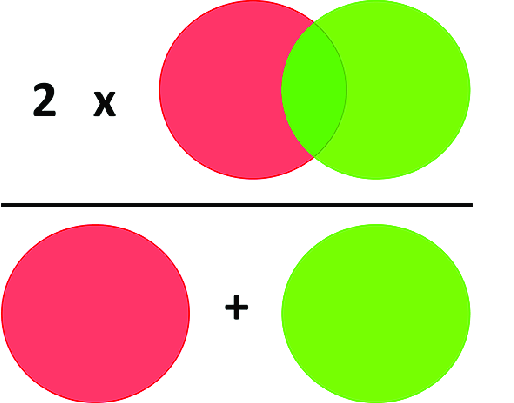

### - Dice similarity coefficient(DSC) == F1 score? YES only if binary segmentation task!
### - What is Dice coefficient loss or Dice loss? Dice loss = 1 - DSC

![](JCSB-07-209-g003.gif)
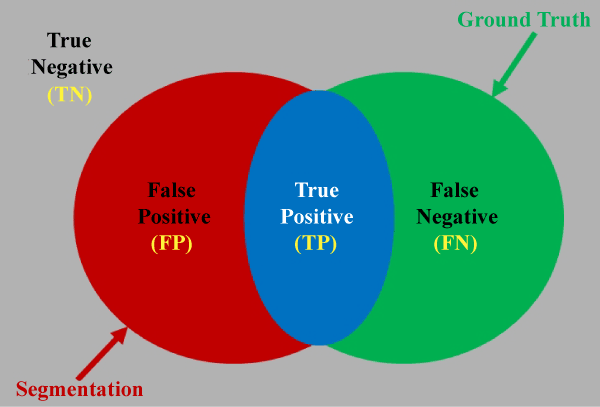

### PREDICTION

In [41]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    predictions = model(images)
    if index == 0:
        break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])


In [42]:
num_classes = 4
print(f"predictions shape: {predictions.shape}")
predictions_ = torch.argmax(predictions, dim=1) # MAX VALUE (4) in torch.Size([4, *4, 224, 224])
print(f"predictions argmax shape: {predictions_.shape}")

predictions shape: torch.Size([4, 4, 224, 224])
predictions argmax shape: torch.Size([4, 224, 224])


In [43]:
# CLASS INDEX -> [0, 1, 2, 3]
# 1 -> [0, 1, 0, 0]
# 2 -> [0, 0, 1, 0]
onehot_pred = F.one_hot(predictions_, num_classes=num_classes)
print(f"onehot pred shape: {onehot_pred.shape}")
onehot_target = F.one_hot(targets, num_classes=num_classes)
print(f"onehot target shape: {onehot_target.shape}")

onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)
onehot_target = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)
print(f"onehot pred after permute shape: {onehot_pred.shape}")
print(f"onehot target after permute shape: {onehot_target.shape}")

onehot pred shape: torch.Size([4, 224, 224, 4])
onehot target shape: torch.Size([4, 224, 224, 4])
onehot pred after permute shape: torch.Size([4, 4, 224, 224])
onehot target after permute shape: torch.Size([4, 4, 224, 224])


In [44]:
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]
print(f"onehot_pred[0] shape: {onehot_pred_.shape}")
print(f"onehot_target[0] shape: {onehot_target_.shape}")

onehot_pred[0] shape: torch.Size([4, 224, 224])
onehot_target[0] shape: torch.Size([4, 224, 224])


### DICE COEFFICIENT

In [45]:
dice_coeff = 0

for class_index in range(1, num_classes): # Excluding Background
    a = onehot_pred_[class_index]
    b = onehot_target_[class_index]
    set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float()) # INTERSECTION
    set_sum = a.sum() + b.sum() # SUM
    dice_coeff += (2 * set_inter) / (set_sum + 1e-9) # 분모가 0인 것을 방지
dice_coeff /= (num_classes-1) # divide bu number of classes, excluding background

In [46]:
dice_coeff

tensor(0.1035)

#### DICE LOSS

In [47]:
dice_loss = 1. - dice_coeff

In [48]:
dice_loss

tensor(0.8965)

### UNET_METRIC

In [49]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return dice_loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [50]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets) # dice_loss, dice_coefficient

(tensor(0.9641), tensor(0.0359))

## LOSS FUNCTION, SGDM OPTIMIZATION

In [51]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")
        
    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)
        loss = loss1 + loss2 # CROSS ENTROPHY + DICE LOSS
        
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [52]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(2.1214, grad_fn=<AddBackward0>), tensor(0.0359))

In [53]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [54]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    criterion(predictions, targets)
    if index == 1:
        break

## SEMENTIC SEGMENTATION

In [55]:
CLASS_ID_TO_RGB = {
    0: (0,0,0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
}

def save_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [56]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    losses = {}
    dice_coefficients = {}

    for phase in ["train", "val"]:
        running_loss = 0.0
        running_dice_coeff = 0.0

        if phase == "train":
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)

            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()

            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Loss: {loss.item():.4f}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}"
                    print(text)

        losses[phase] = running_loss / len(dataloaders[phase])
        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return losses, dice_coefficients

In [57]:
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
# BATCH_SIZE = 2
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [58]:
print(DEVICE)
print(torch.__version__)
print(torch.cuda.is_available())

cuda
1.12.1+cu113
True


START : 13:15
END :

In [60]:
num_epochs = 20

best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_dice_coefficient.append(dice_coefficients["train"])
    val_dice_coefficient.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")
    
    if (epoch > 3) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        
print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

0/1243 - Running Loss: 0.5968 - Running Dice: 0.4294
100/1243 - Running Loss: 0.6542 - Running Dice: 0.3580
200/1243 - Running Loss: 0.5448 - Running Dice: 0.4722
300/1243 - Running Loss: 0.7307 - Running Dice: 0.2845
400/1243 - Running Loss: 0.5782 - Running Dice: 0.4344
500/1243 - Running Loss: 0.6683 - Running Dice: 0.3472
600/1243 - Running Loss: 0.5698 - Running Dice: 0.4450
700/1243 - Running Loss: 0.6923 - Running Dice: 0.3186
800/1243 - Running Loss: 0.4325 - Running Dice: 0.5905
900/1243 - Running Loss: 0.6184 - Running Dice: 0.3963
1000/1243 - Running Loss: 0.6308 - Running Dice: 0.3834
1100/1243 - Running Loss: 0.6135 - Running Dice: 0.4034
1200/1243 - Running Loss: 0.6058 - Running Dice: 0.4060
0/20 - Train Loss: 0.6098, Val Loss: 0.9185
0/20 - Train Dice Coeff: 0.4059, Val Dice Coeff: 0.3406
0/1243 - Running Loss: 0.7180 - Running Dice: 0.2934
100/1243 - Running Loss: 0.5471 - Running Dice: 0.4678
200/1243 - Running Loss: 0.5181 - Running Dice: 0.4938
300/1243 - Running Lo

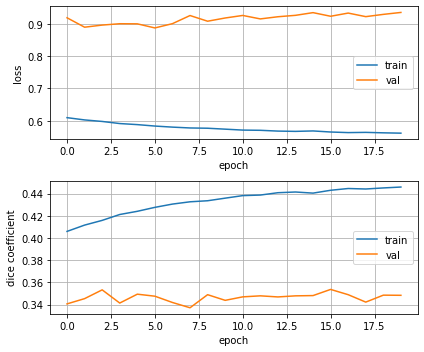

In [61]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_dice_coefficient, label="train")
plt.plot(val_dice_coefficient, label="val")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()

## Morphological filtering

In [62]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [63]:
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [64]:
ckpt_path = "./trained_model/model_15.pth"
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#### morpholocal_process
#### - 각 영역별 필터가 다르기에, 주변의 영역값을 토대로 덥어준다.
#### - Opening
<pre><font size="4">
    0 1 0 0
    1 1 1 0
    1 0 1 1
    1 1 1 0
</pre></font>
<pre><font size="4">
    0 0 0 0
    1 1 1 0
    1 0 1 0
    1 1 1 0
</pre></font>
#### - Closing
<pre><font size="4">
    0 1 0 0
    1 1 1 0
    1 0 1 1
    1 1 1 0
</pre></font>
<pre><font size="4">
    0 1 0 0
    1 1 1 0
    1 1 1 0
    1 1 1 0
</pre></font>


In [66]:
def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize))

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8)
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        new_mask[closing.astype(np.bool_)] = class_index
    return new_mask

In [67]:
def decode_segmap(mask, num_classes):
    mask_H, mask_W = mask.shape
    R_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    G_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)
    B_channel = np.zeros((mask_H, mask_W), dtype=np.uint8)

    for class_index in range(1, num_classes):
        R_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][0]
        G_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][1]
        B_channel[mask == class_index] = CLASS_ID_TO_RGB[class_index][2]
    
    RGB_mask = cv2.merge((B_channel, G_channel, R_channel))
    return RGB_mask

In [68]:
@torch.no_grad()
def predict_segment(image, model, num_classes, device):
    PIL_image = Image.fromarray(image)
    tensor_image = transformer(PIL_image)
    tensor_image = tensor_image.to(device)

    pred_mask = model(torch.unsqueeze(tensor_image, dim=0))
    pred_mask = torch.argmax(pred_mask.squeeze(0).cpu(), dim=0)
    pred_mask = pred_mask.numpy()
    pred_mask = morpholocal_process(pred_mask, num_classes)
    rgb_mask = decode_segmap(pred_mask, num_classes)
    return rgb_mask

In [69]:
video_path = "../data/segmentation/video/test/ID00411637202309374271828.mp4"
cnt = 0
vidcap = cv2.VideoCapture(video_path)
while (vidcap.isOpened()):
    ret, frame = vidcap.read()

    if ret:
        rgb_mask = predict_segment(frame, model, NUM_CLASSES, DEVICE)
        rgb_mask = cv2.resize(rgb_mask, dsize=frame.shape[:2])
              
        alpha = 0.6
        blend = cv2.addWeighted(frame, alpha, rgb_mask, 1-alpha, 0)
        cv2.imshow('output', blend)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey(0)
    else:
        break
        
vidcap.release()
cv2.destroyAllWindows()